In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)
data 

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [3]:
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing' 
filepaths = []
labels = []
folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir,fold)
    filelist = os.listdir(foldpath) 
    for file in filelist:
        fpath = os.path.join(foldpath,file)
        filepaths.append (fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths,name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
dt = pd.concat([Fseries,Lseries],axis='columns')
dt 

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


In [4]:
valid_df,test_df = train_test_split(dt,train_size=0.5,shuffle=True,random_state=123)

In [5]:
batch_size=16
img_size = (224,224)
channels = 3 
img_shape=(img_size[0],img_size[1],channels)  #224*224*3
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( data, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)
test_gen = tr_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= False ,batch_size= batch_size)
valid_gen = tr_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


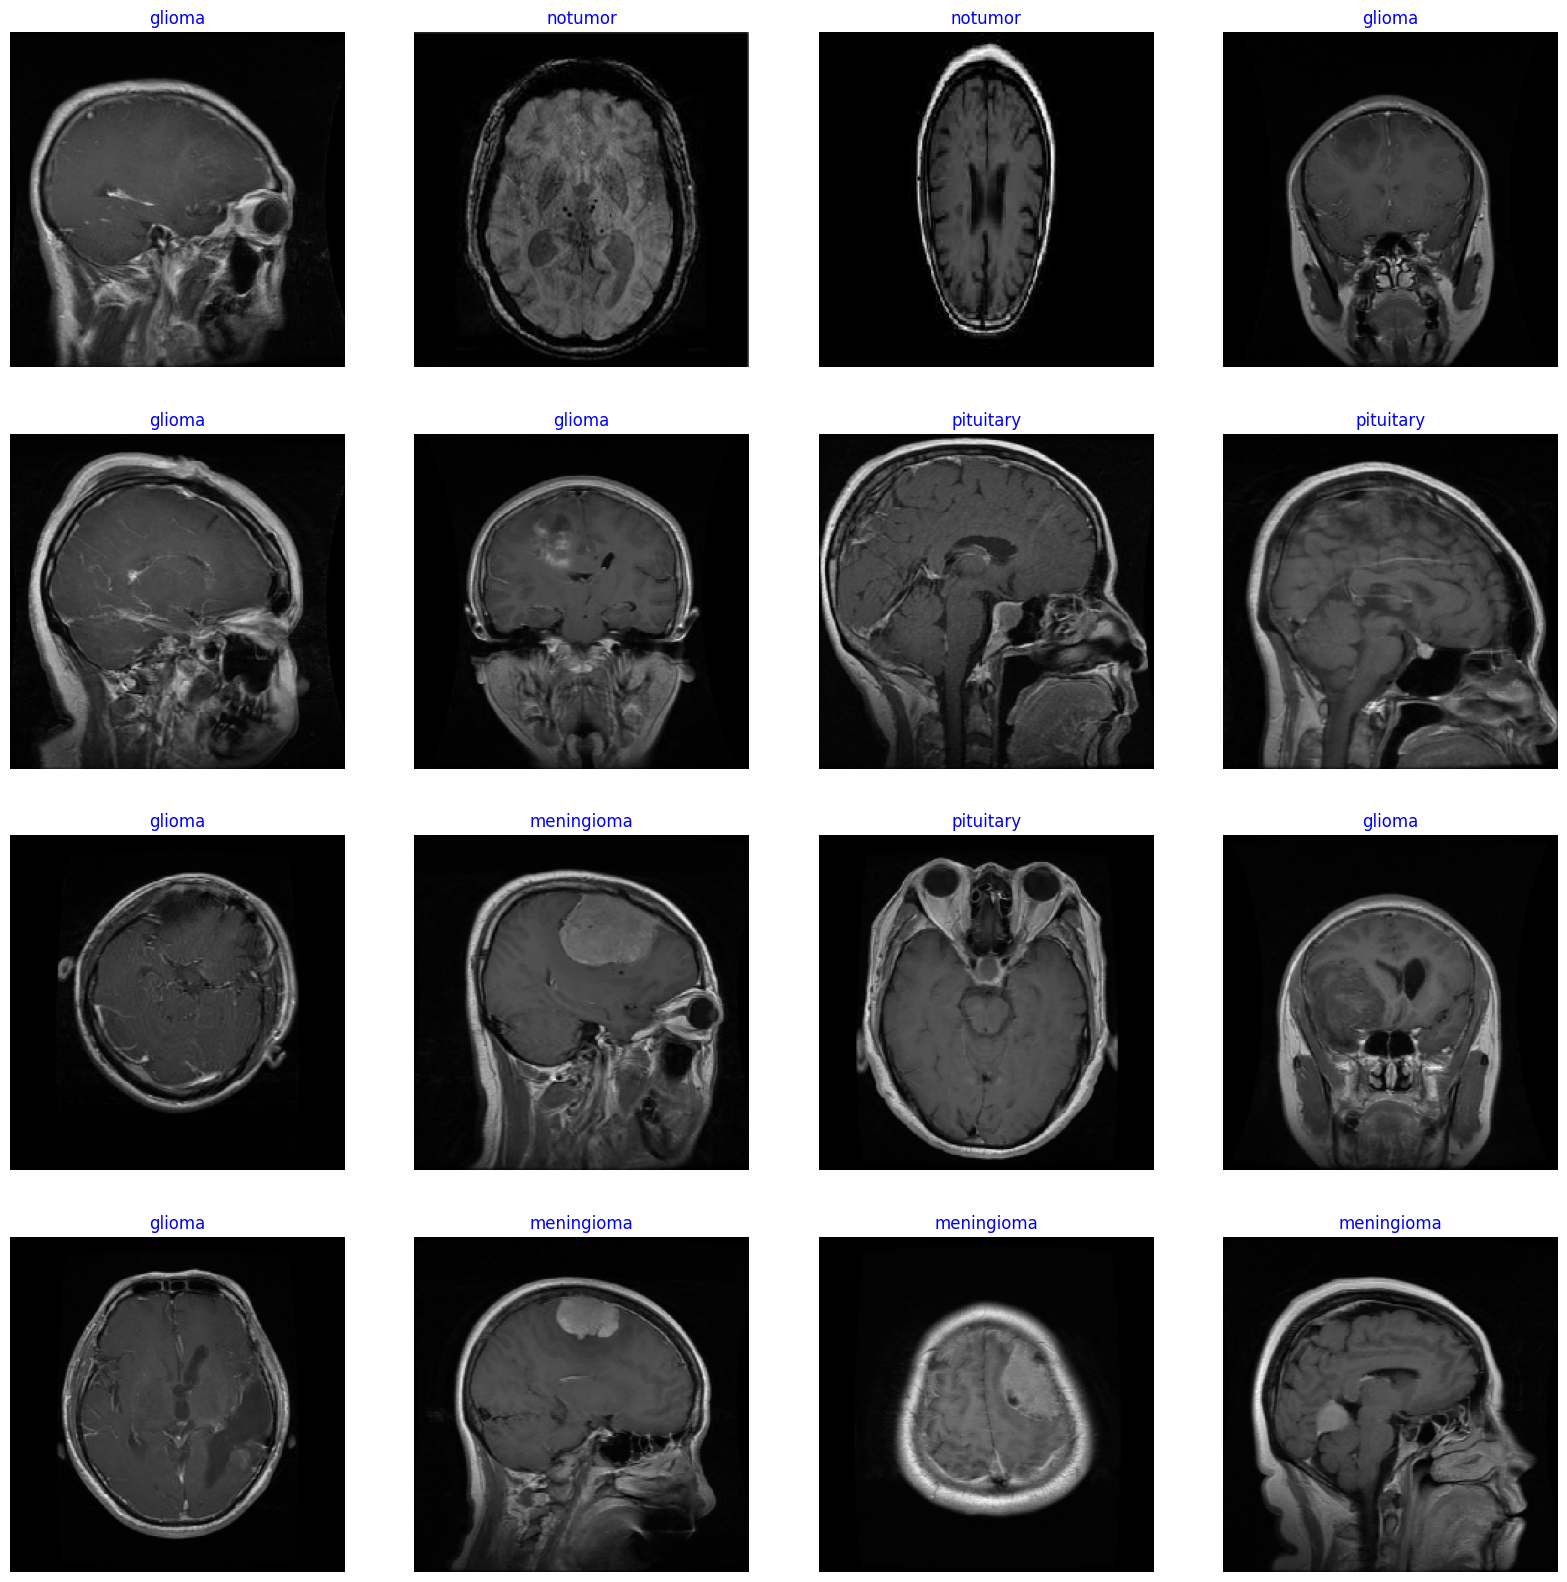

In [6]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images,labels = next(train_gen)
plt.figure(figsize = (20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name= classes[index]
    plt.title(class_name,color='blue',fontsize=12)
    plt.axis('off')
plt.show();

In [7]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.MobileNetV2(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2( 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

# Compile the model
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()
Model: "sequential_1"

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [8]:
epochs = 10
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10


I0000 00:00:1733603516.080813      93 service.cc:145] XLA service 0x795cc8005d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733603516.080874      93 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/357 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.3125 - loss: 21.2456   

I0000 00:00:1733603536.207839      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


357/357 ━━━━━━━━━━━━━━━━━━━━ 83s 120ms/step - accuracy: 0.6620 - loss: 11.0776 - val_accuracy: 0.5237 - val_loss: 6.2770
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.7112 - loss: 4.8027 - val_accuracy: 0.7710 - val_loss: 3.5748
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.7970 - loss: 3.0894 - val_accuracy: 0.8168 - val_loss: 2.2793
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.8598 - loss: 2.0334 - val_accuracy: 0.8702 - val_loss: 1.5433
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.8898 - loss: 1.4195 - val_accuracy: 0.9298 - val_loss: 1.0572
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.8958 - loss: 1.0846 - val_accuracy: 0.9450 - val_loss: 0.8393
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.9183 - loss: 0.9082 - val_accuracy: 0.9542 - val_loss: 0.7501
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.9132 - loss: 0.8083 - val_accur

In [9]:
from sklearn.metrics import classification_report

# Assuming you have test data loaded in test_gen and a trained model named 'model'
# Predict the classes for the test set
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_gen.classes

# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step
              precision    recall  f1-score   support

      glioma       0.97      0.46      0.63       149
  meningioma       0.98      0.80      0.88       143
     notumor       0.66      0.99      0.80       200
   pituitary       0.96      0.99      0.98       164

    accuracy                           0.83       656
   macro avg       0.90      0.81      0.82       656
weighted avg       0.88      0.83      0.82       656



In [10]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define input image size
img_size = 224  # Adjust according to the input size of MobileNetV3Small

# Model definition
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification (tumor vs. non-tumor)
model = Model(inputs=base_model.input, outputs=predictions, name="MobileNetV3Small")  # Set model name

# Print model summary
model.summary()


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,087,089 (4.15 MB)

 Trainable params: 1,074,977 (4.10 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [12]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Assuming you have test data loaded in test_gen and a trained model named 'model'
# Predict the classes for the test set
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_gen.classes

# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Generate classification report as a dictionary
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Calculate overall weighted precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the final precision, recall, and F1-score
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step
Precision: 0.0516
Recall: 0.2271
F1 Score: 0.0841
